# CRI

Corruption risk index will allow us to compare public procurement networks in terms of risky structure.

# CRI

We are going to group by state the following variables:

- Supplier/buyer dispersion
- State-level dispersion
- Proportion of same-state contracts
- Proportion of people suppliers
- Contract daily price
- Contract amount
- File size of the contract
- Proportion of atomized contracts
- Direct award

And compare them to corruption perception in companies and the general population + corruption experience.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

from sklearn import linear_model
from sklearn import preprocessing
from sklearn.impute import SimpleImputer

In [2]:
cnts = pd.read_csv('../data/pre-process/contratos_4.csv')

In [3]:
cnts.columns

Index(['id', 'start_date', 'amount', 'ramo', 'desc_ramo', 'person', 'buyer',
       'file_size', 'single_bid', 'contract_duration', 'prop_window',
       'daily_price', 'contract_type', 'gvmnt_level', 'buyer_state',
       'supplier_country', 'supplier', 'supplier_state', 'state_b', 'code_b',
       'state_s', 'code_s', 'ubuyer', 'usupplier', 'comp', 'long',
       'proportion_window', 'atom', 'buyer_dispersion', 'supplier_dispersion',
       'clustering', 'single_interaction', 'interaction', 's_interaction',
       'CRI', 'year'],
      dtype='object')

In [7]:
cnts.groupby('gvmnt_level')['single_bid'].value_counts(normalize=True)

gvmnt_level  single_bid
F            1             0.737551
             0             0.262449
M            0             0.731360
             1             0.268640
S            0             0.711157
             1             0.288843
Name: single_bid, dtype: float64

In [6]:
cnts['gvmnt_level'].value_counts(normalize=True)

F    0.876156
S    0.085203
M    0.038641
Name: gvmnt_level, dtype: float64

In [4]:
cnts['single_bid'].value_counts(normalize=True)

1    0.681201
0    0.318799
Name: single_bid, dtype: float64

In [2]:
corruption = pd.read_csv("../data/states/federal.csv")
# Contracts dataframe
cnts = pd.read_csv("../data/pre-process/contratos_3.csv",
                  parse_dates=["start_date"])
# Select only studied dates
cnts = cnts[(cnts.start_date < '2020-01-01') & (cnts.start_date > '2010-12-31')]
# Three letter state code
codes = pd.read_csv("../data/states/federal.csv",
                   usecols=["state", "code"])
# Some additional data
inegi = pd.read_csv("../data/inegi/state_data.csv")

In [3]:
cnts = pd.merge(cnts,
                codes,
                how="left",
                left_on="buyer_state",
                right_on="state")

cnts = pd.merge(cnts,
                codes,
                how="left",
                left_on="supplier_state",
                right_on="state",
                suffixes=["_b", "_s"])

In [4]:
#cnts = cnts[cnts['gvmnt_level'] == 'F']

In [5]:
ubuyer = cnts.groupby(['buyer', 'code_b']).code_b.size().rename("N").reset_index().drop("N", axis=1)

ubuyer['ubuyer'] = [f'b_{i}' for i in range(ubuyer.shape[0])]

In [6]:
usupplier = cnts.groupby(['supplier', 'code_s']).code_s.size().rename("N").reset_index().drop("N", axis=1)

usupplier['usupplier'] = [f's_{i}' for i in range(usupplier.shape[0])]

In [7]:
cnts = pd.merge(cnts,
                ubuyer,
                how="left")

In [8]:
cnts = pd.merge(cnts,
                usupplier,
                how="left")

## Corruption

In [9]:
corruption = pd.merge(corruption, codes, how="left")

corruption = corruption.set_index("code")

# INEGI

In [10]:
inegi = pd.merge(inegi, codes, how="left", on="state")

cols_strip = ['population_2015', 'GVA_2011', 'GVA_2012', 'GVA_2013',
       'GVA_2014', 'GVA_2015', 'GVA_2016', 'GVA_2017', 'GVA_2018']

inegi[cols_strip] = inegi[cols_strip].apply(lambda x: x.str.replace(" ", "").astype(float), axis=1)

inegi = inegi.set_index('code')

# Features

# Single Bid

In [11]:
cnts['comp'] = (~cnts.single_bid.astype('boolean')) * 1.

# Contract duration

In [12]:
def long_contract(x):
    if x >= 365:
        return 1
    else:
        return 0

In [13]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
cnts[['contract_duration']] = imp_mean.fit_transform(cnts[['contract_duration']])

In [14]:
cnts['long'] = cnts['contract_duration'].apply(long_contract)

# Proposition window

In [15]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
cnts[['prop_window']] = imp_mean.fit_transform(cnts[['prop_window']])

In [16]:
cnts['proportion_window'] = cnts['prop_window'] / (cnts['contract_duration']+1)

# Atomic contracts

Number of contracts per file. Each contract has a file and we can know how many contracts were in the file.

We define a file as atomized if its number of contracts is larger than 10.

In [17]:
cnts['atom'] = (cnts['file_size'] >= 2) * 1

# Dispersion

We take the variation coefficient ($\frac{\sigma}{\mu}$) of the distribution contracts of each state to any other state.

Let {20, 30, 30, 20} the distribution of contracts bought by state A.

Then $\sigma = 5$ and $\mu = 25$, therefore $\frac{\sigma}{\mu} = 0.2$.

To finish, we normalize by the number of contracts (100), so dispersion of A in contracts bought is $0.002$.

# Dispersion

In a similar way we compute the dispersion of A in contracts sold.

Two other dispersions are calculated:

- Supplier dispersion (by taking the contract distribution of each supplier)
- Buyer dispersion (by taking the contracts of each buyer)

In total we have 4 dispersion measures.

## Dispersion, Two kinds of risk: public and private. 

Let's work with the two by grouping by `buyer_state` and `supplier_state` at the same time.

## Buyer dispersion

In [18]:
def var_coeff(states):
    if np.std(states) == 0:
        return np.nan
    
    return np.std(states) / np.mean(states)

In terms of Buyer

In [31]:
size = cnts.groupby('ubuyer').size().rename('N').reset_index()
size = size[size.N>=35]
size.ubuyer.nunique()
buyers_20 = size.ubuyer.unique()

In [32]:
# Get distribution of contracts per buyer
bv_b = cnts[cnts.ubuyer.isin(buyers_20)].groupby(['ubuyer'])['usupplier'].value_counts().rename('N').reset_index()
# Get number of contracts per buyer
bv_b_n = cnts[cnts.ubuyer.isin(buyers_20)].groupby(['ubuyer']).supplier.size().rename('NC').reset_index()
# Apply variation coefficient
bv_b = bv_b.groupby(
    ['ubuyer']).N.apply(var_coeff).rename('buyer_dispersion').reset_index()
bv_b = pd.merge(bv_b, bv_b_n, how='left')
# Normalize by number of contracts
bv_b['buyer_dispersion'] = bv_b['buyer_dispersion']  / bv_b['NC']
bv_b = bv_b.drop('NC', axis=1)

In [33]:
cnts = pd.merge(cnts, bv_b,
                how="left")

In [34]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
cnts[['buyer_dispersion']] = imp_mean.fit_transform(cnts[['buyer_dispersion']])

# Supplier dispersion

In [35]:
def var_coeff(states):
    #if np.std(states) == 0:
    #    return np.nan
    
    return np.std(states) / np.mean(states)

In [37]:
size = cnts.groupby('usupplier').size().rename('N').reset_index()
size = size[size.N>=10]
suppliers_20 = size.usupplier.unique()

In [38]:
# Get distribution of contracts per supplier
sv_b = cnts[cnts.usupplier.isin(suppliers_20)].groupby(['usupplier'])['ubuyer'].value_counts().rename('N').reset_index()
# Get number of contracts per supplier
sv_b_n = cnts[cnts.usupplier.isin(suppliers_20)].groupby(['usupplier']).buyer.size().rename('NC').reset_index()
# Apply variation coefficient
sv_b = sv_b.groupby(
    ['usupplier']).N.apply(var_coeff).rename('supplier_dispersion').reset_index()
sv_b = pd.merge(sv_b, sv_b_n, how='left')
# Normalize by number of contracts
sv_b['supplier_dispersion'] = sv_b['supplier_dispersion']   / sv_b['NC']
sv_b = sv_b.drop('NC', axis=1)

In [39]:
cnts = pd.merge(cnts, sv_b,
                how="left")

Impute values to mean

In [40]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
cnts[['supplier_dispersion']] = imp_mean.fit_transform(cnts[['supplier_dispersion']])

# Buyer clustering

In [41]:
cnts_notna = cnts.dropna(subset=['usupplier'])
G = nx.from_pandas_edgelist(cnts_notna,
                            source="ubuyer",
                            target="usupplier")

buyers = cnts_notna.ubuyer.unique()
buyers_10 = [b for b in buyers if len(G[b]) >= 20]
c_nodes = nx.bipartite.clustering(G, nodes=buyers_10, mode='max')

c_nodes = [[k, c_nodes[k]] for k in c_nodes]

cluster = pd.DataFrame(c_nodes, columns=['ubuyer', 'clustering'])

cnts = pd.merge(cnts,
         cluster,
         how='left',
         on='ubuyer')

In [42]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
cnts[['clustering']] = imp_mean.fit_transform(cnts[['clustering']])

# Supplier single interaction

In [43]:
data = []
for s in cnts.usupplier.unique():
    if len(G[s]) == 1:
        data.append([s, 1])
    else:
        data.append([s, 0])

In [44]:
repeated = pd.DataFrame(data, columns=['usupplier', 'single_interaction'])

In [45]:
cnts = pd.merge(cnts, repeated, how='left')

In [46]:
cnts['single_interaction'] = cnts['single_interaction'].fillna(0)

In [47]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
cnts[['single_interaction']] = imp_mean.fit_transform(cnts[['single_interaction']])

# Buyer number of contracts over number of neighbors

In [48]:
b_cnts = cnts.groupby('ubuyer').size().rename('interaction').reset_index()

In [49]:
n_cnts = cnts.groupby('ubuyer').supplier.nunique().rename('NN').reset_index()

In [50]:
b_cnts['interaction'] = (b_cnts['interaction'] / n_cnts['NN']) / b_cnts['interaction']

In [51]:
cnts = pd.merge(cnts,
                b_cnts,
                how="left")

In [52]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
cnts[['interaction']] = imp_mean.fit_transform(cnts[['interaction']])

# Supplier number of contracts over number of neighbors

In [53]:
b_cnts = cnts.groupby('supplier').size().rename('s_interaction').reset_index()

In [54]:
n_cnts = cnts.groupby('supplier').buyer.nunique().rename('NN').reset_index()

In [55]:
b_cnts['s_interaction'] = (b_cnts['s_interaction'] / n_cnts['NN']) / b_cnts['s_interaction']

In [56]:
cnts = pd.merge(cnts,
                b_cnts,
                how="left")

In [57]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
cnts[['s_interaction']] = imp_mean.fit_transform(cnts[['s_interaction']])

# Standarization of data

In [58]:
# When we consider all together we have 11 co-variates.

covariates = ['person',
              #'file_size',
              #'single_bid',
              #'comp',
              'buyer_dispersion',
              'long',
              'supplier_dispersion',
              'clustering',
              #'amount',
              'atom',
              'single_interaction',
              'interaction',
              'prop_window',
              'proportion_window',
              'contract_duration']

In [59]:
# cnts_train = cnts.copy()

# r_scaler = preprocessing.RobustScaler(quantile_range=(0., .75), with_centering=False)
# er_scaler = preprocessing.RobustScaler(quantile_range=(0., .75), with_centering=False)
# n_scaler = preprocessing.MinMaxScaler()
# r_features = ['buyer_dispersion', 'clustering']
# r_feature = ['supplier_dispersion']
# n_feature = ['interaction', 'prop_window', 'contract_duration']
# cnts_train[r_features] = r_scaler.fit_transform(cnts_train[r_features])
# cnts_train[r_feature] = er_scaler.fit_transform(cnts_train[r_feature])
# cnts_train[n_feature] = n_scaler.fit_transform(cnts_train[n_feature])

## Put it all together in a linear model

In [60]:
cnts_train = cnts.copy()

ss = cnts_train.groupby("code_b", as_index=False)[['person', 'single_bid']].mean()

ss = pd.merge(ss,
             inegi[["population_2015", "GVA_2015"]],
             left_on="code_b",
             right_index=True)

ss = pd.merge(ss,
              corruption[["very_high_r", "c_very_high_r", "e_exp_r"]],
              how="left",
              left_on="code_b",
              right_index=True)

ss['gva_pc'] = ss['GVA_2015'] / ss['population_2015']

cl = cnts_train.groupby("code_b", as_index=False)[["clustering"]].mean()

sd = cnts_train.groupby("code_b", as_index=False)[["supplier_dispersion"]].mean()

bd = cnts_train.groupby("code_b", as_index=False)[["buyer_dispersion"]].mean()

dp = cnts_train.groupby("code_b", as_index=False)[["daily_price", "amount"]].mean()

fs = cnts_train.groupby("code_b", as_index=False)[['file_size', 'atom']].mean()
si = cnts_train.groupby("code_b", as_index=False)[['single_interaction']].mean()
bc = cnts_train.groupby("code_b", as_index=False)[['interaction']].mean()
pw = cnts_train.groupby("code_b", as_index=False)[['prop_window']].mean()
cd = cnts_train.groupby("code_b", as_index=False)[['contract_duration']].mean()
od = cnts_train.groupby("code_b", as_index=False)[['long']].mean()
co = cnts_train.groupby("code_b", as_index=False)[['comp']].mean()
we = cnts_train.groupby("code_b", as_index=False)[['proportion_window']].mean()





gb = pd.merge(ss, bd)
gb = pd.merge(gb, sd)
gb = pd.merge(gb, dp)
gb = pd.merge(gb, fs)
gb = pd.merge(gb, cl)
gb = pd.merge(gb, si)
gb = pd.merge(gb, bc)
gb = pd.merge(gb, pw)
gb = pd.merge(gb, cd)
gb = pd.merge(gb, od)
gb = pd.merge(gb, co)
gb = pd.merge(gb, we)

# Linear Model

In [61]:
# We fit it in a linear model


X = gb[covariates].values

y = gb['very_high_r'].values

ols = linear_model.LinearRegression()
ols.fit(X, y)

cnts_train['CRI'] = np.inner(cnts_train[covariates].values, ols.coef_) + ols.intercept_

cri = cnts_train.groupby('code_b', as_index=False).CRI.mean()

gb = pd.merge(gb, cri, how='left')

In [62]:
ols.coef_

array([-1.73986407e+01, -6.00674405e+03,  1.34446445e+02, -1.59272316e+03,
       -1.29806679e+03,  2.62930638e+01,  1.00136823e+02,  2.86370076e+02,
       -3.55641023e-01, -1.08221119e-01, -3.01336914e-02])

In [63]:
gb.corr(method='spearman')

,person,single_bid,population_2015,GVA_2015,very_high_r,c_very_high_r,e_exp_r,gva_pc,buyer_dispersion,supplier_dispersion,...,atom,clustering,single_interaction,interaction,prop_window,contract_duration,long,comp,proportion_window,CRI
person,1.000000,-0.113270,-0.418988,-0.466276,-0.073144,-0.069282,-0.124267,-0.134531,0.250000,0.478372,...,-0.352273,-0.375733,0.407991,0.209677,-0.118768,0.216276,0.017595,0.113270,0.049120,-0.201613
single_bid,-0.113270,1.000000,0.269428,0.257331,0.263428,0.142229,0.041789,0.111437,-0.817449,-0.719575,...,-0.006965,-0.119501,-0.510630,-0.758431,-0.090909,-0.374267,-0.245235,-1.000000,0.170088,0.510264
population_2015,-0.418988,0.269428,1.000000,0.747801,0.545921,0.592375,0.082478,-0.233871,-0.391862,-0.324413,...,0.038856,0.024560,-0.219941,-0.184018,-0.226906,0.185484,0.234604,-0.269428,-0.224340,0.428152
GVA_2015,-0.466276,0.257331,0.747801,1.000000,0.324290,0.491935,0.079179,0.362170,-0.306085,-0.403959,...,0.065616,0.055718,-0.234238,-0.282991,-0.179985,-0.010630,0.205279,-0.257331,-0.160557,0.354106
very_high_r,-0.073144,0.263428,0.545921,0.324290,1.000000,0.726856,0.352521,-0.236480,-0.379102,-0.227314,...,0.059578,-0.182218,-0.064161,-0.232081,-0.350687,-0.036114,0.159487,-0.263428,-0.391751,0.508341
c_very_high_r,-0.069282,0.142229,0.592375,0.491935,0.726856,1.000000,0.334677,-0.015029,-0.333944,-0.134164,...,-0.036290,-0.280425,0.152493,-0.174853,-0.489003,0.037023,0.039223,-0.142229,-0.511364,0.552419
e_exp_r,-0.124267,0.041789,0.082478,0.079179,0.352521,0.334677,1.000000,0.105938,-0.259897,-0.105572,...,0.049487,-0.199780,-0.036290,-0.142595,0.010264,-0.218475,-0.162757,-0.041789,-0.348240,0.219941
gva_pc,-0.134531,0.111437,-0.233871,0.362170,-0.236480,-0.015029,0.105938,1.000000,-0.062683,-0.264663,...,-0.015029,0.106672,-0.107771,-0.361804,0.021994,-0.340176,-0.123900,-0.111437,0.085411,0.093842
buyer_dispersion,0.250000,-0.817449,-0.391862,-0.306085,-0.379102,-0.333944,-0.259897,-0.062683,1.000000,0.731672,...,-0.201613,0.160557,0.384164,0.791422,0.162757,0.361804,0.337243,0.817449,-0.034824,-0.756965
supplier_dispersion,0.478372,-0.719575,-0.324413,-0.403959,-0.227314,-0.134164,-0.105572,-0.264663,0.731672,1.000000,...,-0.501833,-0.364370,0.609971,0.658358,-0.119135,0.441716,0.195015,0.719575,0.010264,-0.527859


In [64]:
cnts_train[covariates + ['CRI']].corr('pearson')

,person,buyer_dispersion,long,supplier_dispersion,clustering,atom,single_interaction,interaction,prop_window,proportion_window,contract_duration,CRI
person,1.000000,0.042466,-0.017573,0.080344,-0.090517,-0.099179,0.272738,0.019113,-0.029298,-0.003787,0.078000,-0.018707
buyer_dispersion,0.042466,1.000000,0.032710,0.154856,0.203919,-0.054892,0.046662,0.223037,0.003050,0.009026,0.054418,-0.279978
long,-0.017573,0.032710,1.000000,0.021709,0.040275,0.055748,-0.004428,0.008901,0.012618,-0.001472,0.646565,0.350472
supplier_dispersion,0.080344,0.154856,0.021709,1.000000,-0.062117,-0.122740,-0.114554,0.061666,-0.004250,-0.000564,0.064629,-0.472009
clustering,-0.090517,0.203919,0.040275,-0.062117,1.000000,0.393263,-0.134706,0.042970,0.038346,0.012055,0.068582,-0.163963
atom,-0.099179,-0.054892,0.055748,-0.122740,0.393263,1.000000,-0.095461,-0.051192,0.062684,0.009837,0.083080,0.116986
single_interaction,0.272738,0.046662,-0.004428,-0.114554,-0.134706,-0.095461,1.000000,0.022665,-0.005815,0.002651,0.043023,0.500170
interaction,0.019113,0.223037,0.008901,0.061666,0.042970,-0.051192,0.022665,1.000000,-0.002488,0.001733,0.016645,0.042976
prop_window,-0.029298,0.003050,0.012618,-0.004250,0.038346,0.062684,-0.005815,-0.002488,1.000000,0.457127,0.015430,-0.562395
proportion_window,-0.003787,0.009026,-0.001472,-0.000564,0.012055,0.009837,0.002651,0.001733,0.457127,1.000000,-0.004127,-0.300956


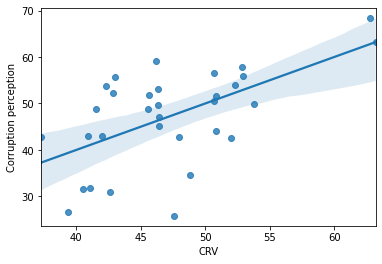

In [65]:
sns.regplot(x='CRI', y='very_high_r', data=gb)
plt.ylabel("Corruption perception")
plt.xlabel("CRV")
#plt.xlim([29, 70])
plt.savefig("../figures/corruption_risk_perception.png", dpi=300)

In [66]:
cnts['CRI'] = cnts_train['CRI']
cnts['ubuyer'] = cnts_train['ubuyer']
cnts['usupplier'] = cnts_train['usupplier']

In [71]:
cnts['year'] = cnts.start_date.dt.year

cnts = cnts.dropna(subset=['usupplier', 'ubuyer'])

In [73]:
cnts.to_csv("../data/pre-process/contratos_4.csv", index=False)